In [401]:
# load data from csv file and save data into separate lists
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.fftpack import fft, ifft
from sklearn.decomposition import PCA
import warnings

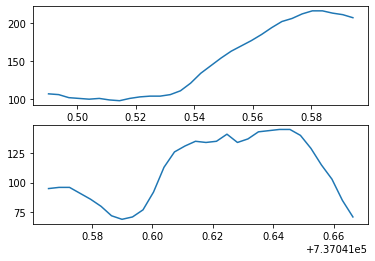

In [273]:
# this part is just showing what is the figures look like and 
i = 0
a = pd.read_csv('.\DataFolder\CGMDatenumLunchPat'+str(i+1)+'.csv')
b = pd.read_csv('.\DataFolder\CGMSeriesLunchPat'+str(i+1)+'.csv')
plt.figure(1)
plt.subplot(211)
plt.plot(a.iloc[15],b.iloc[15])
plt.subplot(212)
plt.plot(a.iloc[23],b.iloc[23])
plt.show()

In [393]:
# when read the data from CSV, the time stamp and associated GMC value should be reversed
def read_raw_data():
    x =[]
    y =[]

    for i in range (5):
        x_p=[]
        y_p=[]
        with open(r'.\DataFolder\CGMDatenumLunchPat'+str(i+1)+'.csv','rt')as f:
            data = csv.reader(f)
#             rows_x=[row for idx, row in enumerate(data) if idx<=20]# only use first 20 rows of the data
            for row in data:
                x_p.append(row)
        with open(r'.\DataFolder\CGMSeriesLunchPat'+str(i+1)+'.csv','rt')as ff:
            data = csv.reader(ff)
#             rows_y=[row for idx, row in enumerate(data) if idx<=20]# only use first 20 rows of the data
            for row in data:
                y_p.append(row)
        if i==0:
            x = x_p[1:]
            y = y_p[1:]
        elif i!=0:
            x = x+x_p[1:]
            y = y+y_p[1:]
    return x,y
        

# this func is used to remove the data which contains 'NaN' and only use the first 30 data
def smooth_data(x,y):
    idx = []
    size_y = len(y)
#     print("size: ", size_y)
    for i in range (size_y):
        x[i] = x[i][:30]
        y[i] = y[i][:30]
        if 'NaN' in y[i]:
#             print('here',i)
            idx.append(i)
#     print(idx)        
    for j in range (len(idx),0,-1):
        del y[idx[j-1]]
        del x[idx[j-1]]
    return x,y

In [396]:
x,y = read_raw_data()
print('Number of rows from the raw data:',len(y))

x,y = smooth_data(x,y)
print("Number of rows from the processed data: ",len(y) )

Number of rows from the raw data: 216
Number of rows from the processed data:  186


In [364]:
# this shows an example of preprocessed data
print(len(y[40]))
array_x = np.asarray(x[5])
array_y = np.asarray(y[5],dtype=int)
print(array_y)

30
[ 88  87  87  87  90  94  98  98  96  95  97 106 128 144 159 173 186 199
 210 212 218 222 226 222 217 212 211 214 215 215]


In [343]:
# function for calculating the avg of changing velocity with window size 6, result in 6 features
def avg_vel(y):
    vel_y = []
    avg_vel = []
    window_size = 5
    for i in range (len(y)-1):
        vel = y[i+1]-y[i]
        vel_y.append(vel)
    np.asarray(vel_y)
    for i in range (int(len(y)/window_size)):
        if i != (int((len(y)/window_size)-1)):
            avg = np.average(vel_y[(i*6):(i*6)+6])
        avg_vel.append(avg)
    array_vel = np.asarray(avg_vel)
    array_vel = normalize(array_vel[:,np.newaxis], axis=0).ravel()
#     print('This is the avg_vel feature: ',array_vel)
    return array_vel

# polynomial curve fitting result in 6 features
def polyfit_coeff(y):
    xx = np.arange(30)
    z = np.polyfit(xx, y, 5)
    zz = normalize(z[:,np.newaxis], axis=0).ravel()
#     print('This is the polyfit_coeff feature: ',zz)
    return zz

# distribution of mutual_info_score with window_size 6, result in 5 features
def mutual_info_distribution(y):
    window_size = 5
    score = []
    for j in range (int(len(y)/window_size)-1):
        if j != (int((len(y)/window_size)-2)):
            i = j*6
            score_part = normalized_mutual_info_score(y[i:i+6], y[i+6:i+12])
        elif j == (int((len(y)/window_size)-2)):
            i = j*6
            score_part = normalized_mutual_info_score(y[i:i+6], y[0:6])
        score.append(score_part)
    score = np.asarray(score)
    final_score = normalize(score[:,np.newaxis], axis=0).ravel()
#     print('This is the mutual_info distribution feature: ',final_score)
    return final_score

def FFT_feature(y):
    yf = 2.0/30 * np.abs(fft(y))
#     xf = np.linspace(0.0, 1.0, 15)
    yf = np.delete(yf,0)
    yf = np.unique(yf)
    max_yf = np.partition(yf,-6)[-6:]
    max_yf = np.asarray(max_yf)
    final_yf = normalize(max_yf[:,np.newaxis], axis=0).ravel()
#     print('This is the FFT feature: ',final_yf)
    return final_yf
    

In [335]:
# this is the result of four different kinds of features
cc = avg_vel(array_y)

zz = polyfit_coeff(array_y)

bb = mutual_info_distribution(array_y)

ss = FFT_feature(array_y)

This is the avg_vel feature:  [ 0.11334023  0.34002068  0.92938987  0.07933816 -0.02720165 -0.02720165]
This is the polyfit_coeff feature:  [ 3.44403455e-06 -2.45865628e-04  5.76829186e-03 -4.72749195e-02
  1.36840670e-01  9.89447512e-01]
This is the mutual_info distribution feature:  [0.38696147 0.49723932 0.49723932 0.45390281 0.38696147]
This is the FFT feature:  [0.10160786 0.10654766 0.12640083 0.15792334 0.19773933 0.94778987]


C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

In [399]:
# merge all feature into feature matrix
for i in range(len(y)):
    yy = np.asarray(y[i],dtype=np.float32)
    f1 = avg_vel(yy)
    f2 = polyfit_coeff(yy)
    f12 = np.concatenate((f1, f2), axis=None)
    f3 = mutual_info_distribution(yy)
    f4 = FFT_feature(yy)
    f34 = np.concatenate((f3, f4), axis=None)
    f1234 = np.concatenate((f12, f34), axis=None)
    if i == 0:
        feature_m = f1234
    else:
        feature_m = np.vstack((feature_m,f1234))


C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_m

In [400]:
print(feature_m)
print(feature_m.shape)

[[-0.09629194 -0.37553856 -0.90514427 ...  0.22445865  0.22937293
   0.92350191]
 [ 0.40598604  0.22474226 -0.0144995  ...  0.1153206   0.22210474
   0.96153635]
 [ 0.37008959 -0.31721964 -0.86354244 ...  0.13692814  0.18059872
   0.96316582]
 ...
 [-0.05853329 -0.65849948 -0.52679962 ...  0.18211113  0.37194628
   0.88576442]
 [-0.17087707 -0.51263118 -0.51263118 ...  0.16113059  0.35374698
   0.90432668]
 [-0.61668158 -0.64536446  0.05736573 ...  0.2135738   0.54870784
   0.74609667]]
(186, 23)


In [414]:
pca = PCA()
pca.fit(feature_m)
X = pca.fit_transform(feature_m)
explain = pca.explained_variance_ratio_
print(explain)

[2.81755565e-01 2.56451347e-01 1.69245684e-01 1.41710116e-01
 9.92167892e-02 3.34622215e-02 6.00938967e-03 3.40501881e-03
 2.31925290e-03 2.22409572e-03 1.91949858e-03 6.51051832e-04
 4.83699559e-04 4.60304144e-04 3.93181722e-04 1.96107747e-04
 4.92720332e-05 2.54326017e-05 2.19008576e-05 7.08020229e-08
 6.53614025e-12 6.64621451e-17 3.40548702e-34]


In [417]:
components = abs(pca.components_)
print(components)

[[4.47203625e-02 5.14071862e-01 6.81438888e-01 2.93258501e-03
  3.61279450e-01 3.61279450e-01 6.04477002e-07 3.79094137e-05
  5.93099301e-04 1.06515299e-03 1.92995609e-02 1.93393969e-03
  5.76499053e-03 1.38573097e-02 2.73635202e-03 1.77203110e-02
  7.48358056e-03 7.59428696e-03 7.91995224e-03 5.39654559e-03
  1.99416220e-02 7.50710706e-02 3.39654550e-02]
 [9.93875291e-02 3.17915264e-01 2.83224983e-01 4.95367957e-01
  5.18087319e-01 5.18087319e-01 4.33040600e-07 3.40867114e-05
  9.23333353e-04 1.07981655e-02 3.15854093e-02 3.63248845e-03
  1.65274416e-03 3.72105658e-03 4.48598971e-03 8.11654016e-03
  6.75858038e-03 2.38820903e-02 3.44695595e-02 3.83154308e-02
  6.56879419e-02 9.91511277e-02 8.92652477e-02]
 [5.09562433e-01 3.57921027e-01 5.31183198e-01 4.64964847e-01
  2.21517294e-01 2.21517294e-01 1.81163937e-06 1.29402043e-04
  3.14340594e-03 2.81222477e-02 4.30052389e-02 2.24110171e-03
  1.45394341e-02 7.13028419e-04 1.06835389e-02 1.93492547e-02
  1.86032211e-02 2.62000056e-02 4.08